# Assignment 10 - Viraj Noorithaya


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-10" if code_mode == "development" else "main"
folder_name = "Session 10/Submission"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


## Code Procurement


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf "era-v1" && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "era-v1" && git checkout {branch_name} && cd "{folder_name}"

Cloning into 'era-v1'...
remote: Enumerating objects: 1053, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1053 (delta 33), reused 41 (delta 20), pack-reused 984
Receiving objects: 100% (1053/1053), 6.61 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (526/526), done.
Branch 'week-10' set up to track remote branch 'week-10' from 'origin'.
Switched to a new branch 'week-10'


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder
from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import sys

print(f"CWD: {os.getcwd()}")

if model_run_location == "colab":
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: /content
Appending folder to path in order to detect modules: Session 10/Submission


In [6]:
# Import user defined modules
from modules.dataset import split_cifar_data, apply_cifar_image_transformations
from modules.dataset import CIFAR_MEAN, CIFAR_STD, CIFAR_CLASSES
from modules.custom_resnet import CustomResNet as Net
from modules.trainer import train_and_test_model
from modules.utils import get_device, save_model, pretty_print_metrics
from modules.visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [7]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Specify the number of epochs
NUM_EPOCHS = 24

# Set the batch size
BATCH_SIZE = 512

# Set seed value for reproducibility
SEED = 8

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device


In [8]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [9]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# cutout needs to be half of the image size
cutout_size = 8

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=CIFAR_MEAN, std=CIFAR_STD, cutout_size=cutout_size
)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## Train/Test Split


In [10]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data



100%|██████████| 170498071/170498071 [00:13<00:00, 12929482.94it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [11]:
# For reproducibility
torch.manual_seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)

# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

In [12]:
# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


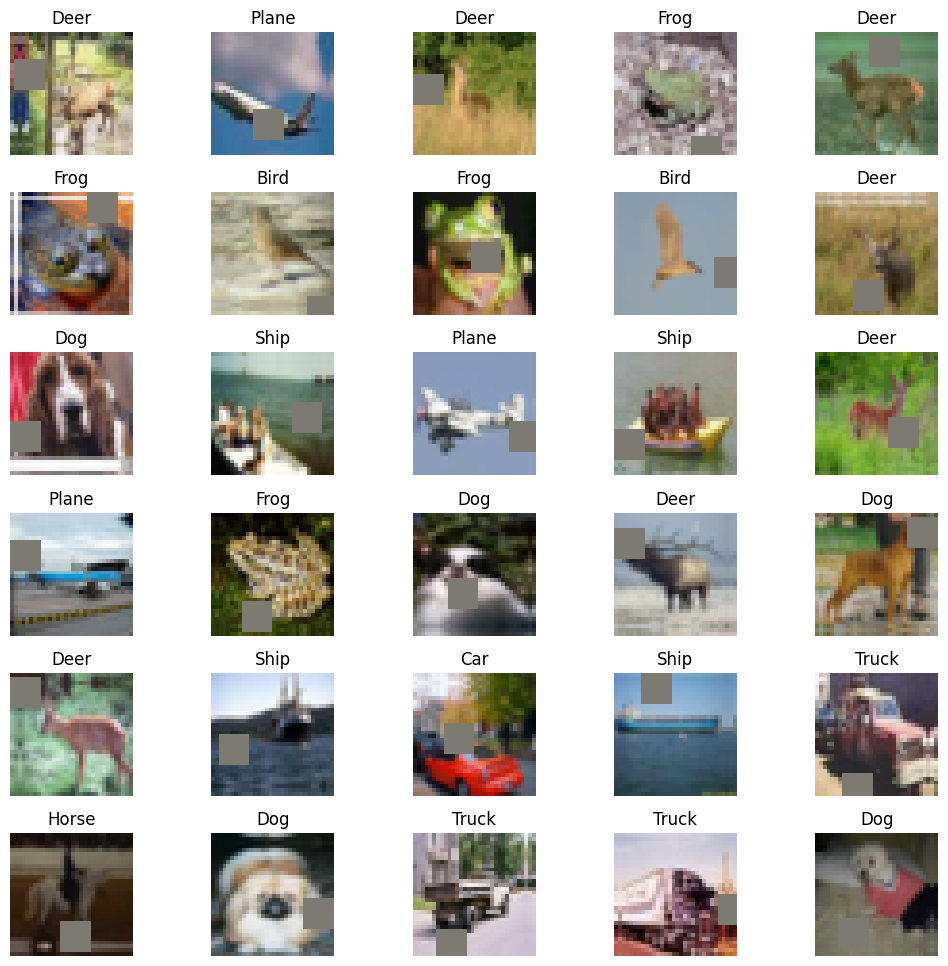

In [13]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [14]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# Print the model summary by specifying the input size
summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
 torch.Size([2, 64, 32, 32]) 

Layer 1, X 
 torch.Size([2, 128, 16, 16]) 

Layer 1, R1 
 torch.Size([2, 128, 16, 16]) 

Layer 1, X + R1 
 torch.Size([2, 128, 16, 16]) 

Layer 2 
 torch.Size([2, 256, 8, 8]) 

Layer 3, X 
 torch.Size([2, 512, 4, 4]) 

Layer 3, R2 
 torch.Size([2, 512, 4, 4]) 

Layer 3, X + R2 
 torch.Size([2, 512, 4, 4]) 

Max Pooling 
 torch.Size([2, 512, 1, 1]) 

Reshape before FC 
 torch.Size([2, 512]) 

After FC 
 torch.Size([2, 10]) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReL

## Train and Test


### Optimizer and Loss Function


In [15]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.64E-02


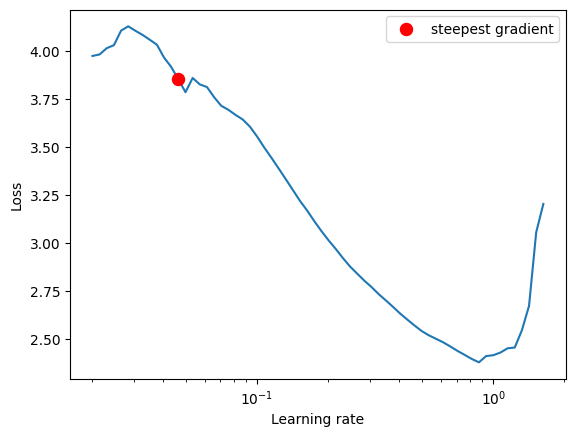

In [16]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader=train_loader, start_lr=1e-7, end_lr=10, num_iter=100)
plot, optimal_lr = lr_finder.plot(suggest_lr=True)
lr_finder.reset()

### Scheduler


In [17]:
# # Learning rate scheduler based on plateau
# # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
# )

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=optimal_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
    verbose=True,
)

Adjusting learning rate of group 0 to 4.6416e-04.


### Train and test model


In [18]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 24


Epoch 1


Train: Loss=1.0012, Batch_id=97, Accuracy=52.19: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Test set: Average loss: 0.0021,  Accuracy: 6314/10000  (63.14%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 5.5813e-04.


Epoch 2


Train: Loss=0.7461, Batch_id=97, Accuracy=70.50: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]


Test set: Average loss: 0.0014,  Accuracy: 7580/10000  (75.80%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 6.5210e-04.


Epoch 3


Train: Loss=0.5705, Batch_id=97, Accuracy=77.96: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Test set: Average loss: 0.0012,  Accuracy: 7977/10000  (79.77%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 7.4607e-04.


Epoch 4


Train: Loss=0.5294, Batch_id=97, Accuracy=81.27: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Test set: Average loss: 0.0011,  Accuracy: 8142/10000  (81.42%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 8.4004e-04.


Epoch 5


Train: Loss=0.4660, Batch_id=97, Accuracy=84.52: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0009,  Accuracy: 8446/10000  (84.46%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 9.3401e-04.


Epoch 6


Train: Loss=0.3287, Batch_id=97, Accuracy=86.18: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0009,  Accuracy: 8432/10000  (84.32%)
Adjusting learning rate of group 0 to 1.0280e-03.


Epoch 7


Train: Loss=0.3532, Batch_id=97, Accuracy=87.43: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0010,  Accuracy: 8390/10000  (83.90%)
Adjusting learning rate of group 0 to 1.1220e-03.


Epoch 8


Train: Loss=0.2911, Batch_id=97, Accuracy=88.65: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0009,  Accuracy: 8614/10000  (86.14%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 1.2159e-03.


Epoch 9


Train: Loss=0.2779, Batch_id=97, Accuracy=89.47: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Test set: Average loss: 0.0009,  Accuracy: 8417/10000  (84.17%)
Adjusting learning rate of group 0 to 1.3099e-03.


Epoch 10


Train: Loss=0.3451, Batch_id=97, Accuracy=90.66: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]


Test set: Average loss: 0.0009,  Accuracy: 8604/10000  (86.04%)
Adjusting learning rate of group 0 to 1.4039e-03.


Epoch 11


Train: Loss=0.2431, Batch_id=97, Accuracy=91.00: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0008,  Accuracy: 8731/10000  (87.31%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 1.4978e-03.


Epoch 12


Train: Loss=0.3157, Batch_id=97, Accuracy=91.42: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0007,  Accuracy: 8804/10000  (88.04%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 1.5918e-03.


Epoch 13


Train: Loss=0.1929, Batch_id=97, Accuracy=92.62: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


Test set: Average loss: 0.0007,  Accuracy: 8839/10000  (88.39%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 1.6858e-03.


Epoch 14


Train: Loss=0.2638, Batch_id=97, Accuracy=92.87: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0007,  Accuracy: 8859/10000  (88.59%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 1.7798e-03.


Epoch 15


Train: Loss=0.2063, Batch_id=97, Accuracy=92.79: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Test set: Average loss: 0.0006,  Accuracy: 8966/10000  (89.66%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 1.8737e-03.


Epoch 16


Train: Loss=0.2580, Batch_id=97, Accuracy=93.68: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Test set: Average loss: 0.0007,  Accuracy: 8940/10000  (89.40%)
Adjusting learning rate of group 0 to 1.9677e-03.


Epoch 17


Train: Loss=0.2164, Batch_id=97, Accuracy=93.64: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0010,  Accuracy: 8656/10000  (86.56%)
Adjusting learning rate of group 0 to 2.0617e-03.


Epoch 18


Train: Loss=0.2187, Batch_id=97, Accuracy=93.98: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]


Test set: Average loss: 0.0009,  Accuracy: 8748/10000  (87.48%)
Adjusting learning rate of group 0 to 2.1556e-03.


Epoch 19


Train: Loss=0.1972, Batch_id=97, Accuracy=93.67: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]


Test set: Average loss: 0.0008,  Accuracy: 8816/10000  (88.16%)
Adjusting learning rate of group 0 to 2.2496e-03.


Epoch 20


Train: Loss=0.1935, Batch_id=97, Accuracy=94.42: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]


Test set: Average loss: 0.0007,  Accuracy: 8894/10000  (88.94%)
Adjusting learning rate of group 0 to 2.3436e-03.


Epoch 21


Train: Loss=0.1077, Batch_id=97, Accuracy=95.12: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0007,  Accuracy: 8983/10000  (89.83%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 2.4375e-03.


Epoch 22


Train: Loss=0.1738, Batch_id=97, Accuracy=94.91: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


Test set: Average loss: 0.0008,  Accuracy: 8951/10000  (89.51%)
Adjusting learning rate of group 0 to 2.5315e-03.


Epoch 23


Train: Loss=0.1027, Batch_id=97, Accuracy=95.01: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0007,  Accuracy: 9033/10000  (90.33%)
Saving the model as best test accuracy till now is achieved!
Adjusting learning rate of group 0 to 2.6255e-03.


Epoch 24


Train: Loss=0.1490, Batch_id=97, Accuracy=95.52: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]


Test set: Average loss: 0.0008,  Accuracy: 8825/10000  (88.25%)
Adjusting learning rate of group 0 to 2.7195e-03.




In [19]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

Epoch: 01, Train Loss: 1.3436, Test Loss: 0.0021, Train Accuracy: 52.1860, Test Accuracy: 63.1400
Epoch: 02, Train Loss: 0.8404, Test Loss: 0.0014, Train Accuracy: 70.5020, Test Accuracy: 75.8000
Epoch: 03, Train Loss: 0.6351, Test Loss: 0.0012, Train Accuracy: 77.9580, Test Accuracy: 79.7700
Epoch: 04, Train Loss: 0.5404, Test Loss: 0.0011, Train Accuracy: 81.2740, Test Accuracy: 81.4200
Epoch: 05, Train Loss: 0.4506, Test Loss: 0.0009, Train Accuracy: 84.5160, Test Accuracy: 84.4600
Epoch: 06, Train Loss: 0.3986, Test Loss: 0.0009, Train Accuracy: 86.1800, Test Accuracy: 84.3200
Epoch: 07, Train Loss: 0.3629, Test Loss: 0.0010, Train Accuracy: 87.4340, Test Accuracy: 83.9000
Epoch: 08, Train Loss: 0.3254, Test Loss: 0.0009, Train Accuracy: 88.6480, Test Accuracy: 86.1400
Epoch: 09, Train Loss: 0.3043, Test Loss: 0.0009, Train Accuracy: 89.4680, Test Accuracy: 84.1700
Epoch: 10, Train Loss: 0.2736, Test Loss: 0.0009, Train Accuracy: 90.6580, Test Accuracy: 86.0400
Epoch: 11, Train Los

## Metrics


Expected accuracy: 90.0%
Plotting accuracy and loss graphs.


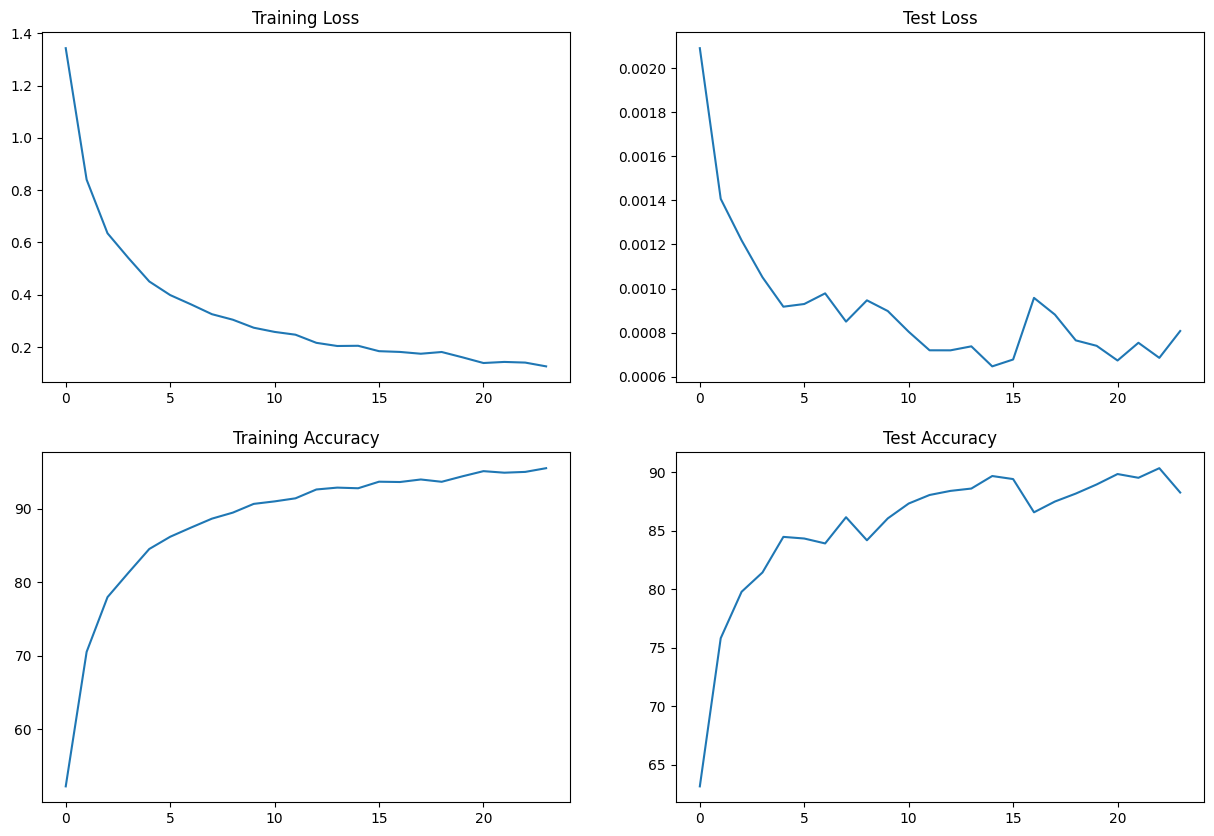

In [20]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()

## Save model


In [21]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show incorrect images


In [22]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()

ValueError: ignored

<Figure size 1000x0 with 0 Axes>